In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
import scipy.linalg as la

from scipy.linalg import expm
from qiskit.quantum_info import Statevector, partial_trace, Operator, DensityMatrix
from qiskit.visualization import plot_state_qsphere, plot_histogram, plot_bloch_multivector

np.set_printoptions(precision=3)

In [154]:
def init_hamiltonian(N):
    """The uniform matrix"""
    v = np.ones((N,1))*(1/np.sqrt(N))
    return np.matmul(v, v.T.conj())

def init_vector(N):
    return np.ones((N,1))*(1/np.sqrt(N))
    
def problem_vector(N):
    pv = np.zeros((N,1))
    pv[N-1] = 1
    return pv
    
def problem_hamiltonian(N):
    pv = problem_vector(N)
    return np.matmul(pv, pv.T.conj())

def H_op(delt, n, H):
    """
    Input:
        delt: time interval
        n: number of qubits
        H: Hamiltonian matrix
    return Operator exp(-itH)
    """
    H = H*(-1j*delt)
    exp_H = expm(H)
    h = QuantumCircuit(n, name = 'H_op')
    h.unitary(exp_H, range(n))
    return h.to_gate()

def f(t, epsilon, N):
    """
    Time evolve function
    Input:
        t: time point
        epsilon: error value
        N: 2**n
    return value from 0 to 1
    """
    arg = ((2*epsilon*np.sqrt(N-1)*t)/N - np.arctan(np.sqrt(N-1)))
    num = np.tan(arg) / np.sqrt(N-1)
    den = 1 + num
    result = 0.5 * den
    return result

def getT(epsilon, N):
    t1 = 1/(2*epsilon)
    t2 = N/np.sqrt(N-1)
    t3 = np.arctan((np.sqrt(N-1)))+np.arctan(np.sqrt(N-1))
    return t1*t2*t3

def getR(epsilon, N):
    """get the total iteration R"""
    return (int)(np.sqrt(N)/(epsilon**3))

def get_state(qc):
    m = DensityMatrix(qc)
    v = m.to_statevector()
    return v
    
def getEpsilon1(final_vector, m):
    """
    get the epsilon of the result, should lower than the theoretical epsilon

    ERRORS: Have problems!
    """
    distance_vector = final_vector.copy()
    distance_vector[m-1] -= 1
    values = np.matmul(distance_vector.conj().T,distance_vector)
    return np.sqrt(values)

def getEpsilon2(v1, v2):
    """return from 0 to 1"""
    res = np.matmul(v1.T.conj(), v2)
    return (1-(abs(res))**2)[0]

def get_eH(a, delt, f):
    H = np.array([[f, (f-1)*a],
                       [-f*a, 1-f]], dtype=complex)
    m = H*(-1j*delt)
    exp_H = expm(m)
    return exp_H

def get_norm(v):
    return np.sqrt(np.matmul(v.T.conj(), v))

def normalize_vector(v):
    n = get_norm(v)
    v = v/n
    return v

## Compare two ways to express the error

Total time T: 6.045997880780727
Total iteration R: 31
State: [-0.169-0.231j -0.169-0.231j -0.169-0.231j  0.868+0.j   ]
E1: (0.5131993402787784+0j)
E2: 0.2460321544588422


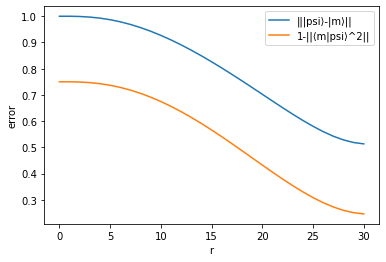

In [124]:
n = 2
N = 2**n
epsilon = 0.4

rs = []
es1 = []
es2 = []

T = getT(epsilon, N)
R = getR(epsilon, N)

circ = QuantumCircuit(n)
circ.h(range(n))

for r in range(0, R):
    t = r*(T/R)
    H0 = np.identity(N) - init_hamiltonian(N)
    Hp = np.identity(N) - problem_hamiltonian(N)
    circ.append(H_op(T/R,n,(1-f(t,epsilon,N))*H0), range(n))
    circ.append(H_op(T/R,n,f(t,epsilon,N)*Hp), range(n))

    rs.append(r)
    state = get_state(circ)
    es1.append(getEpsilon1(state.data, N))
    es2.append(getEpsilon2(state.data, problem_vector(N)))


print("Total time T: " +str(T))
print("Total iteration R: " +str(R))
print("State: " +str(state.data))
print("E1: " + str(getEpsilon1(state.data, N)))
print("E2: " + str(getEpsilon2(state.data, problem_vector(N))))

plt.plot(rs, es1, label="|||psi⟩-|m⟩||")
plt.plot(rs, es2, label="1-||⟨m|psi⟩^2||")
plt.xlabel("r")
plt.ylabel("error")
plt.legend()

# plot_state_qsphere(Statevector(circ))

## Simulate reduced matrix numerically e^H

Total time T: 123.22348147575705
Total iteration R: 499
State: [[0.235-0.473j]
 [0.663+0.565j]]
E1: [[0.843+0.j]]
E2: [0.241]


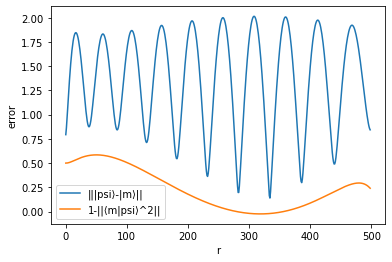

In [191]:
n = 10
N = 2**n
epsilon = 0.4

rs = []
states = []
es1 = []
es2 = []
ns = []

T = getT(epsilon, N)
R = getR(epsilon, N)
a = 1/np.sqrt(N)
delt = T/R
state = init_vector(2)

for r in range(0, R):
    t = r*(T/R)
    op = get_eH(a, delt, f(t,epsilon,N))
    state = np.dot(op, state)
#     state = normalize_vector(state)
    
    rs.append(r)
    states.append(state)
    es1.append(getEpsilon1(state, 2)[0][0])
    es2.append(getEpsilon2(state, problem_vector(2))[0])
    ns.append(get_norm(state)[0][0])


print("Total time T: " +str(T))
print("Total iteration R: " +str(R))
print("State: " +str(state))
print("E1: " + str(getEpsilon1(state, 2)))
print("E2: " + str(getEpsilon2(state, problem_vector(2))))


plt.plot(rs, es1, label="|||psi⟩-|m⟩||")
plt.plot(rs, es2, label="1-||⟨m|psi⟩^2||")
plt.xlabel("r")
plt.ylabel("error")
plt.legend()


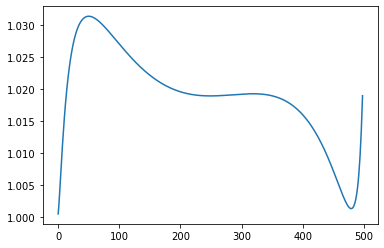

In [192]:
    # print(ns)
plt.plot(rs, ns)